# Graded Exercise 2: Anomaly Detection on Acoustic Data

- **Course**: [CIVIL-426 - Machine Learning for Predictive Maintenance](https://edu.epfl.ch/coursebook/en/machine-learning-for-predictive-maintenance-applications-CIVIL-426)
- **Start Date**: 2024.10.03 at 10:15
- **Due Date**: 2024.10.16 at 23:59
- **Student 0**:
    - Name: Joshua Cohen-Dumani
    - SCIPER: 311105
- **Student 1**:
    - Name: Sophea Bonne
    - SCIPER: 352901

# Introduction
Anomalous sound detection (ASD) refers to the task of identifying whether the sounds emitted from a target machine are normal or anomalous.
In real-world industrial environments, anomalies are infrequent and can exhibit significant variability, making it impractical to build an exhaustive set of anomalous sound patterns.
As a result, our goal is to detect anomalous sounds using only normal sound clips for training.

This challenge cannot be approached as a simple classification problem (anomaly vs healthy). Instead, it is formulated as a **one-class classification** problem, where the model is trained on normal sound data to detect deviations from the learned pattern.

Anomalous sound detection can be achieved with following steps:
   - Feature Extraction (I)
   - One-class Classifier Training (II)
   - Decisions based on a threshold from your trained classifier (III)
   
Through this assignment, you will primarily focus on tasks (I) and (II).
The quality of your one-class classifier will be assessed using the **Area Under the Curve (AUC)** score on the test dataset.

The model used here is a type of neural network called **AutoEncoder** (AE). AE is trained to reconstruct the input data while compressing the input data into a lower-dimensional latent space and minimizing information loss during this process.
Thus, you will also modify the extracted features and Neural Network used in this notebook to improve the anomalous sound detection performance.

The dataset is composed of two different machines, a Pump and a Valve. For each machine you have:
- A **training dataset** composed of *only healthy* sound data
- A **test dataset** composed of *both healthy and abnormal* sound data

# Questions:

Your task is to improve the anomalous sound detection performance by modifying the feature extraction process and neural network architecture. You are expected to experiment with various feature representations and neural network configurations to optimize detection results.

Specifically, the following questions must be addressed. Each question should be discussed separately for both the Pump and Valve datasets. The answers are to be provided in a PDF report, and the full Jupyter notebook must also be submitted.

**Question 1:** Given the provided code, fill in the blank spaces to extract signal features, train a simple AutoEncoder that reconstructs the inputs MEL-Spectogram, and report the AUC score.

**Question 2:** From the trained AutoEncoder, use the bottleneck features to train both (1) a One-Class SVM and (2) an Isolation Forest, and report the corresponding AUC scores.

**Question 3:** Instead of using AutoEncoder features, apply PCA to project the MEL-spectrogram into a smaller dimensional space, then train (1) a One-Class SVM and (2) an Isolation Forest, and report the AUC scores.

**Question 4:** Determine an appropriate threshold for distinguishing anomalies based on the given results, and compute the following metrics: Accuracy, True Positive Rate (TPR), False Positive Rate (FPR), and F1-score.

**Question 5:** Visualize essential steps and provide a thorough discussion of the results obtained from all the methods.  

**Bonus Question:** Modify the AutoEncoder architecture to a 2D AutoEncoder using convolutional layers instead of fully connected layers, and analyze its performance.

## Download Dataset

In [1]:
%pip install gdown --upgrade --quiet
import gdown
import os

Note: you may need to restart the kernel to use updated packages.


In [2]:
# pump dataset
if not os.path.exists('dev_data_pump_04'):
    print('Downloading and unzipping dev_data_pump_04.zip...')
    gdown.download(id='1ZAqnNW2gnHDyFHGHk3Aru7k-ng-BTpGn', output="./dev_data_pump_04.zip")
    !unzip dev_data_pump_04.zip
else:
    print('Directory dev_data_pump_04 already exists, skipping download and unzip.')


Directory dev_data_pump_04 already exists, skipping download and unzip.


In [3]:
# Valve Dataset
if not os.path.exists('dev_data_valve_00'):
    print('Downloading and unzipping dev_data_valve_00.zip...')
    gdown.download(id='1H_SS7qteLcd44e5CD9CFJjhJ573FAb6M', output="./dev_data_valve_00.zip")
    !unzip dev_data_valve_00.zip
else:
    print('Directory dev_data_valve_00 already exists, skipping download and unzip.')

Directory dev_data_valve_00 already exists, skipping download and unzip.


In case that above links do not work, you can also manully download the dataset here:
- **dev_data_pump_04.zip**: https://docs.google.com/uc?export=download&id=1ZAqnNW2gnHDyFHGHk3Aru7k-ng-BTpGn
- **dev_data_valve_00,zip**: https://docs.google.com/uc?export=download&id=1H_SS7qteLcd44e5CD9CFJjhJ573FAb6M

## Import Dependency

In [4]:
import sys
import librosa
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from tqdm import tqdm

## Audio Data Loading and MEL-Spectrogram Feature Extraction

The code is adapted from https://github.com/MIMII-hitachi/mimii_baseline

Copyright (C) 2019 Hitachi, Ltd. All right reserved.

Harsh Purohit, Ryo Tanabe, Kenji Ichige, Takashi Endo, Yuki Nikaido, Kaori Suefusa, and Yohei Kawaguchi, "MIMII Dataset: Sound Dataset for Malfunctioning Industrial Machine Investigation and Inspection," arXiv preprint arXiv:1909.09347, 2019.

In [40]:
########################################################################
# import additional python-library
########################################################################
import librosa.core
import librosa.feature

# WAV File Input
def load_wav_files(wav_file_name, mono=True):
    """Load a .wav file."""
    try:
        return librosa.load(wav_file_name, sr=None, mono=mono)
    except Exception as e:
        print(f"Failed to load file '{wav_file_name}'. Error: {e}")
        raise

def demux_wav_files(wav_file_name, channel=0):
    """Demux a .wav file and return a specific channel."""
    try:
        multi_channel_data, sr = load_wav_files(wav_file_name, mono=False)
        if multi_channel_data.ndim == 1:
            return sr, multi_channel_data
        return sr, multi_channel_data[channel, :]
    except ValueError as e:
        print(f"Error in demuxing file '{wav_file_name}': {e}")
        raise

# Feel free to modify and analysis the images in your report
def plot_signals(tmin, tmax, sr, y, emphasized_y, log_mel_spectrogram):
    plt.figure(1)
    n = len(y)
    t = np.linspace(tmin, tmax, n)
    plt.plot(t, y)
    plt.xlim(t[0],t[-1])
    plt.xlabel('time/s',fontsize=20)
    plt.ylabel('Amplitude',fontsize=20)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid()
    
    plt.figure(2)
    freq = sr/n*np.linspace(0,n/2,int(n/2)+1)
    plt.plot(freq,np.absolute(np.fft.rfft(y[tmin*sr:tmax*sr],n)**2)/n)
    plt.xlim(0,5000)
    plt.xlabel('Frequency/Hz',fontsize=14)
    
    plt.figure(3)
    plt.plot(freq,np.absolute(np.fft.rfft(emphasized_y,n)**2)/n)
    plt.xlim(0,5000)
    plt.xlabel('Frequency/Hz',fontsize=14)
    
    plt.figure(4)
    librosa.display.specshow(log_mel_spectrogram)
    plt.colorbar()

########################################################################
# Feature Extractor
########################################################################
def file_to_features(file_name,
                     n_mels=64,
                     frames=5,
                     n_fft=1024,
                     hop_length=512,
                     power=2.0,
                     plot=True):
    """Convert a WAV file to a vector array."""
    # Step 01: Load the demuxed wav files
    sr, y = demux_wav_files(file_name, channel=0)
    
    # Step 02: Signal Pre-emphasis
    tmin = int(0)
    tmax = int(len(y)/sr)
    alpha = 0.95
    emphasized_y = np.append(y[0],
                             y[1:] - alpha*y[:-1])
    
    # Step 03: Generate MEL-Spectrogram
    # ===================================
    mel_spec = librosa.feature.melspectrogram(y=y, 
                                              sr=sr, 
                                              n_fft=n_fft, 
                                              hop_length=hop_length, 
                                              power=power, 
                                              n_mels=n_mels)
    # ===================================

    # Step 04: Convert MEL-Spectrogram to log scale
    # ===================================
    log_mel_spectrogram = librosa.power_to_db(mel_spec, ref=np.max)
    # ===================================
    
    
    # Step 05: Define Feature Vector Array
    dims = n_mels * frames
    length = len(log_mel_spectrogram[0,:]) - frames + 1
    features = np.zeros((length, dims), float)
    
    # Pad short clips instead of skipping
    if length < 1:
        print(f"Audio file '{file_name}' is too short. Padding applied.")
        log_mel_spectrogram = np.pad(log_mel_spectrogram, ((0, 0), (0, frames - 1)), mode='constant')
        length = 1
    
    for t in range(frames):
        features[:, n_mels * t: n_mels * (t + 1)] = log_mel_spectrogram[:, t: t + length].T
    
    if plot:
        plot_signals(tmin, tmax, sr, y, emphasized_y, log_mel_spectrogram)
    return features

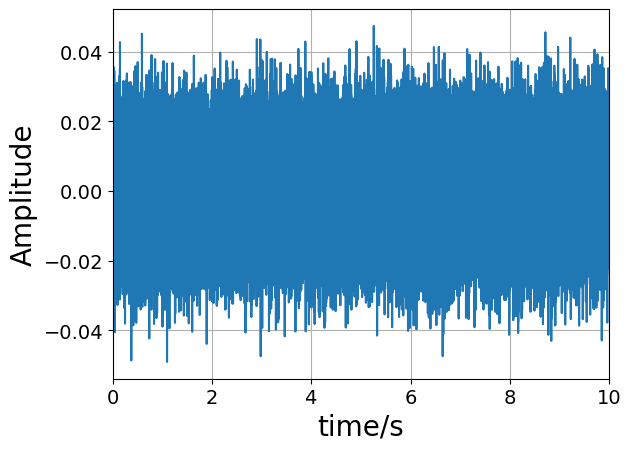

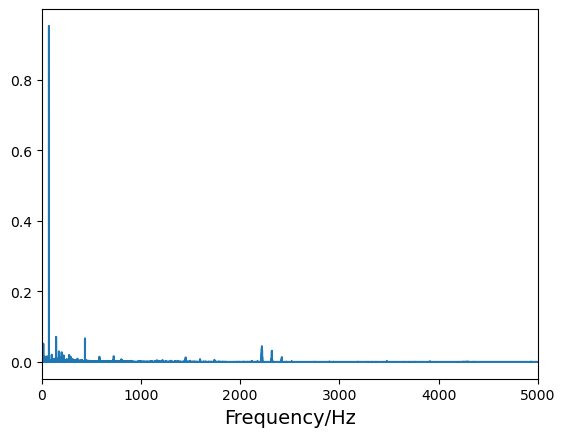

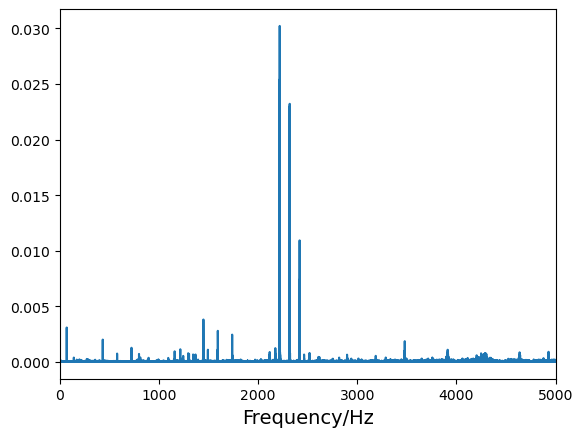

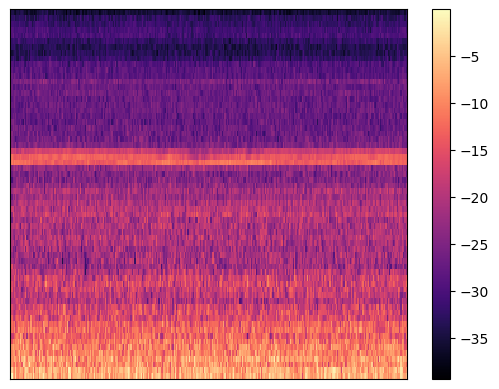

In [41]:
wav_test_file = 'dev_data_pump_04/pump/train/normal_id_04_00000000.wav'
# wav_test_file = 'dev_data_pump_04/pump/test/anomaly_id_04_00000000.wav'

# Visualize your results for potential analysis in your report
features = file_to_features(wav_test_file)

## PyTorch Dataset Splitting

To define and optimize a neural network, we will use the library [PyTorch](http://pytorch.org).

In [7]:
DATA_PATH = "."
MACHINE = "pump_04" # Choice between  "valve_00" or "pump_04"

In [8]:
class MIMII(Dataset):
    def __init__(self, root, machine, train=True, transform=None, target_transform=None):
        if train:
            self.audio_path = os.path.join(root, f"dev_data_{machine}", machine.split("_")[0], "train")
            self.audio_files = os.listdir(self.audio_path)
            self.labels = [int(f.split("_")[0] == "anomaly") for f in self.audio_files]
        else:
            self.audio_path = os.path.join(root, f"dev_data_{machine}", machine.split("_")[0], "test")
            self.audio_files = os.listdir(self.audio_path)
            self.labels = [int(f.split("_")[0] == "anomaly") for f in self.audio_files]
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.audio_files)

    def __getitem__(self, idx):
        file_path = os.path.join(self.audio_path, self.audio_files[idx])
        label = self.labels[idx]
        if self.transform:
            f = self.transform(file_path)
        else:
            # default feature representation
            f = file_to_features(file_path).astype(np.float32)
        if self.target_transform:
            label = self.target_transform(label)
        return f, label

In [9]:
# Parameters of the feature extraction
melsp_params = dict(n_mels=64,
                    frames=1,
                    n_fft=1024,
                    hop_length=512,
                    power=2.0,
                    plot=False)


feature_extraction_pipeline = T.Compose([
    T.Lambda(lambda file: file_to_features(file, **melsp_params).astype(np.float32)),
    T.ToTensor()
])

In [10]:
# Pytorch train/test datasets
data_train = MIMII(
    root=DATA_PATH,
    machine=MACHINE,
    train=True,
    transform=feature_extraction_pipeline
)

data_test = MIMII(
    root=DATA_PATH,
    machine=MACHINE,
    train=False,
    transform=feature_extraction_pipeline
)

## AutoEncoder Model Definition

In [11]:
class DenseAutoencoder(nn.Module):

    def __init__(self, input_dim):
        super(DenseAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            )
        
        # Symetrical neural network to the encoder to reconstuct the input
        # ===================================
        self.decoder = nn.Sequential(
        nn.Linear(32, 128),        
        nn.ReLU(),
        nn.Linear(128, 512),      
        nn.ReLU(),
        nn.Linear(512, input_dim), 
        )
        # ===================================

    def forward(self, x):
        feature = self.encoder(x)
        reconstruction = self.decoder(feature)
        return reconstruction,feature

In [12]:
duration = 10  # s
sr = 16000  # Hz
input_dim = int(duration * sr / melsp_params["hop_length"] + 1) * melsp_params["n_mels"] * melsp_params["frames"]
model = DenseAutoencoder(input_dim)

## Training

In [13]:
# Training parameters
batch_size = 32
epochs = 10

In [14]:
# PyTorch data loaders allow to iterate batch-wise over a dataset
train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True, drop_last=True)

In [15]:
# Stochastic gradient descent optimizer
optimizer = torch.optim.Adam(model.parameters())

# Mean Squared Error (MSE) loss function to be minimized
loss_fn = nn.MSELoss()

In [16]:
def train_loop(dataloader, model, loss_fn, optimizer, print_every=10):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    loss_running = 0
    for batch, (x, y) in enumerate(tqdm(dataloader)):
        # Compute prediction and loss
        x = x.flatten(start_dim=1)
        optimizer.zero_grad()
        x_pred, features = model(x)
        
        # TODO : write the loss function, compute the gradient, and update the model parameters
        # ===================================
        loss = loss_fn(x_pred, x)
        loss.backward()
        optimizer.step()
        # ===================================
        
        # Back Propagation
        loss_running += loss.item()
    print(f"loss: {loss_running/len(dataloader):>7f}")


def test_loop(dataset, model, loss_fn):
    size = len(dataset)
    test_losses = np.zeros(size)
    store_feature = []
    with torch.no_grad():
        for idx, (x, _) in enumerate(dataset):
            x = x.flatten()
            x_pred,features = model(x)
            store_feature.append(features.detach().cpu().numpy())
            test_losses[idx] = loss_fn(x_pred, x).item()

    return test_losses, np.array(store_feature)

In [17]:
%%time
for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train_loop(train_loader, model, loss_fn, optimizer, print_every=1);

Epoch 1
-------------------------------


100%|██████████| 18/18 [00:03<00:00,  4.89it/s]


loss: 160.738073
Epoch 2
-------------------------------


100%|██████████| 18/18 [00:05<00:00,  3.10it/s]


loss: 17.658186
Epoch 3
-------------------------------


100%|██████████| 18/18 [00:06<00:00,  2.79it/s]


loss: 12.910281
Epoch 4
-------------------------------


100%|██████████| 18/18 [00:06<00:00,  2.65it/s]


loss: 12.455836
Epoch 5
-------------------------------


100%|██████████| 18/18 [00:06<00:00,  2.63it/s]


loss: 12.300363
Epoch 6
-------------------------------


100%|██████████| 18/18 [00:03<00:00,  5.22it/s]


loss: 12.346519
Epoch 7
-------------------------------


100%|██████████| 18/18 [00:02<00:00,  6.55it/s]


loss: 12.336360
Epoch 8
-------------------------------


100%|██████████| 18/18 [00:03<00:00,  5.63it/s]


loss: 12.303464
Epoch 9
-------------------------------


100%|██████████| 18/18 [00:02<00:00,  6.22it/s]


loss: 12.244011
Epoch 10
-------------------------------


100%|██████████| 18/18 [00:02<00:00,  6.70it/s]

loss: 12.220305
CPU times: user 2min 30s, sys: 8.49 s, total: 2min 39s
Wall time: 44.6 s


## Prediction and Evaluation

## NOTE: Still need to clean up this section

Note: We will be computing the "optimal" threshold using Youden's J statistic in order to find a good first guess. However since in practice, in anomaly detection it is more important to optimize for True Positive Rate, then we could also imagine a further exercise trying to find the "optimal" threshold for us based on some cost optimisation (using the cost of a false positive vs. false negative). For this exercise set we will stick to Youden's J-statistic which weighs both TPR and FPR equally high. 

In [23]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score

y_true = data_test.labels
test_losses, extracted_features_test = test_loop(data_test, model, loss_fn)
y_scores = test_losses

# Define a threshold based on test loss for classification
# Report accuracy, TPR, FPR, F1-Score
# ===================================
roc_auc = metrics.roc_auc_score(y_true, y_scores)
print(f"ROC AUC Score: {roc_auc:.4f}")

# Compute ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_true, y_scores)

# Compute the Youden's J statistic
J = tpr - fpr
idx = np.argmax(J)
optimal_threshold = thresholds[idx]
print(f"Optimal Threshold (Youden's J): {optimal_threshold:.4f}")

# Classify samples based on the optimal threshold
y_pred = (y_scores >= optimal_threshold).astype(int)

# Compute confusion matrix
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

# Compute metrics
accuracy = accuracy_score(y_true, y_pred)
tpr_value = recall_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
fpr_value = fp / (fp + tn)

# Print the results
print(f"Accuracy: {accuracy:.4f}")
print(f"True Positive Rate (Recall): {tpr_value:.4f}")
print(f"False Positive Rate: {fpr_value:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1-Score: {f1:.4f}")
# ===================================

ROC AUC Score: 0.8245
Optimal Threshold (Youden's J): 11.5866
Accuracy: 0.7500
True Positive Rate (Recall): 0.9600
False Positive Rate: 0.4600
Precision: 0.6761
F1-Score: 0.7934


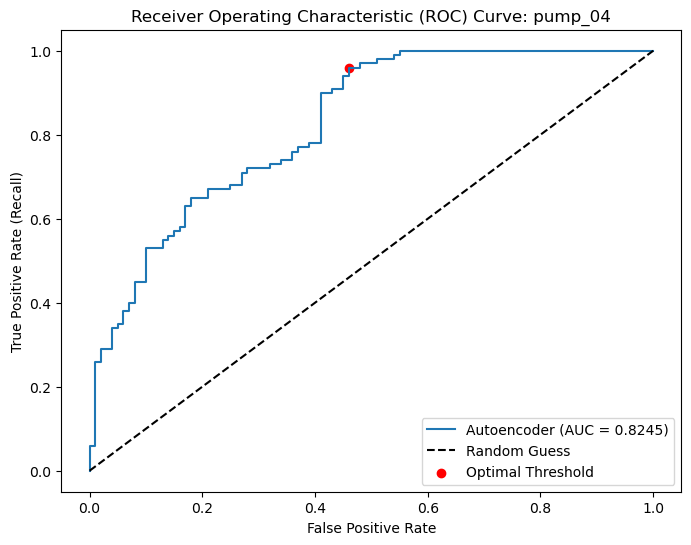

In [29]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Autoencoder (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.scatter(fpr_value, tpr_value, color='red', label='Optimal Threshold')
plt.title(f'Receiver Operating Characteristic (ROC) Curve: {MACHINE}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.legend()
plt.show()

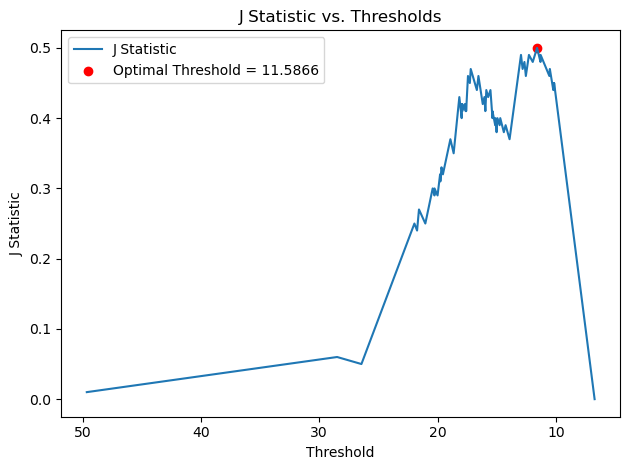

In [28]:
plt.plot(thresholds, J, label="J Statistic")
plt.scatter(optimal_threshold, J[idx], color='red', label=f'Optimal Threshold = {optimal_threshold:.4f}')
plt.title("J Statistic vs. Thresholds")
plt.xlabel('Threshold')
plt.ylabel("J Statistic")
plt.legend()
plt.gca().invert_xaxis() 
plt.tight_layout()
plt.show()

In [30]:
def compute_reconstruction_losses(dataset, model, loss_fn):
    size = len(dataset)
    losses = np.zeros(size)
    with torch.no_grad():
        for idx, (x, _) in enumerate(dataset):
            x = x.flatten()
            x_pred, _ = model(x)
            losses[idx] = loss_fn(x_pred, x).item()
    return losses

In [31]:
# Compute reconstruction losses on training data
train_losses = compute_reconstruction_losses(data_train, model, loss_fn)

In [32]:
# Choose the percentile for the threshold (e.g., 95th percentile)
percentile = 95

# Compute the threshold
threshold = np.percentile(train_losses, percentile)
print(f"Threshold (at {percentile}th percentile): {threshold}")

Threshold (at 95th percentile): 21.12275943756102


In [33]:
# Compute predictions on test data
y_true = data_test.labels  # Actual labels (0: normal, 1: anomaly)

# y_scores were previously computed reconstruction losses on test data
# y_scores = test_losses  # Assuming you have this from your earlier code

# Classify test samples based on the threshold
y_pred = (y_scores >= threshold).astype(int)

In [34]:
# Compute confusion matrix
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

# Compute metrics
accuracy = accuracy_score(y_true, y_pred)
tpr_value = recall_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
fpr_value = fp / (fp + tn)

# Print the results
print(f"Accuracy: {accuracy:.4f}")
print(f"True Positive Rate (Recall): {tpr_value:.4f}")
print(f"False Positive Rate: {fpr_value:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1-Score: {f1:.4f}")

Accuracy: 0.6300
True Positive Rate (Recall): 0.2900
False Positive Rate: 0.0300
Precision: 0.9062
F1-Score: 0.4394


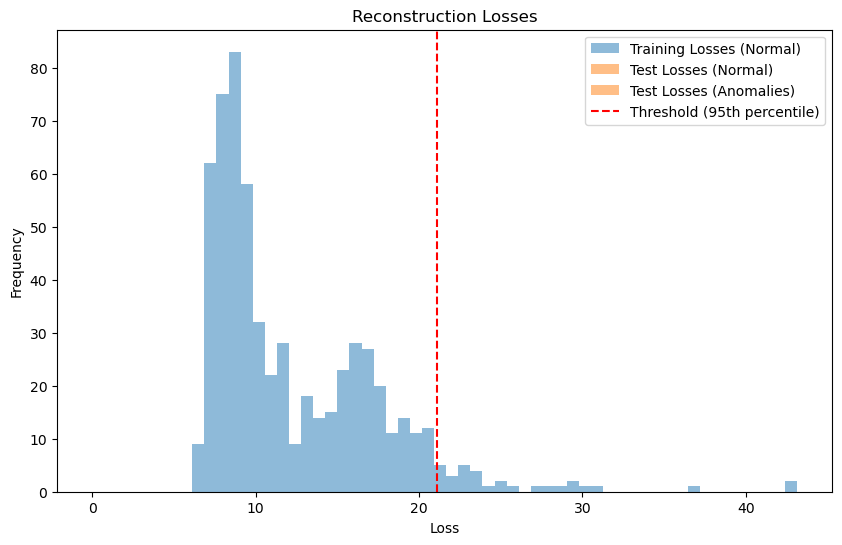

In [35]:
plt.figure(figsize=(10, 6))
plt.hist(train_losses, bins=50, alpha=0.5, label='Training Losses (Normal)')
plt.hist(y_scores[y_true == 0], bins=50, alpha=0.5, label='Test Losses (Normal)')
plt.hist(y_scores[y_true == 1], bins=50, alpha=0.5, label='Test Losses (Anomalies)')
plt.axvline(threshold, color='red', linestyle='--', label=f'Threshold ({percentile}th percentile)')
plt.title('Reconstruction Losses')
plt.xlabel('Loss')
plt.ylabel('Frequency')
plt.legend()
plt.show()

## One-Class SVM and Isolation Forest

From the trained AutoEncoder, use the bottleneck features to train a (1) One-Class SVM and (2) Isolation Forest, and report the accuracy, F1-score and auc score of each method.

In [ ]:
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest

In [ ]:
# Get normal training features
y_pred_train, extracted_features_train = test_loop(data_train, model, loss_fn)

### One-Class SVM

In [ ]:
# TODO : Define the OneClassSVM here
# TODO : Fit OneClassSVM here using training data
# TODO : Report essential evaluation metrics
# ===================================
# IMPLEMENT YOUR CODE HERE
# ===================================

metrics.roc_auc_score(y_true, -predicted_score)

### Isolation Forest

In [ ]:
# TODO : Define IsolationForest here
# TODO : Fit IsolationForest here using training data
# TODO : Report essential evaluation metrics
# ===================================
# IMPLEMENT YOUR CODE HERE
# ===================================

metrics.roc_auc_score(y_true, -predicted_score)

PCA of the spectrograms to reduce the input dimension

In [ ]:
# Extract spectrograms of training and testing
flatten_spectogram_train = []
for idx, (x, _) in enumerate(data_train):
    x = x.flatten()
    flatten_spectogram_train.append(x.numpy())
train_spec = np.array(flatten_spectogram_train)

flatten_spectogram_test = []
for idx, (x, _) in enumerate(data_test):
    x = x.flatten()
    flatten_spectogram_test.append(x.numpy())
test_spec = np.array(flatten_spectogram_test)

Apply PCA to fit and transform the training data and transform also the test data

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=64)

# TODO : Fit and transform the training data (train_spec)
# TODO : Transform the testing data (test_spec)
# ===================================
# IMPLEMENT YOUR CODE HERE
# ===================================

Apply OneClassSVM and IsolationForest on the new PCA features.

In [ ]:
# TODO : Define the OneClassSVM here
# TODO : Fit OneClassSVM here using PCA features
# TODO : Report essential evaluation metrics
# ===================================
# IMPLEMENT YOUR CODE HERE
# ===================================

metrics.roc_auc_score(y_true, -predicted_score)

In [ ]:
# TODO : Define IsolationForest here
# TODO : Fit IsolationForest here using PCA features
# TODO : Report essential evaluation metrics
# ===================================
# IMPLEMENT YOUR CODE HERE
# ===================================

metrics.roc_auc_score(y_true, -predicted_score)